In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import pickle
import os
from PIL import Image
import numpy as np

from tqdm import tqdm
import torch.nn.functional as F
import torch
from torch import nn
from torch.utils.data import Dataset
from PIL import Image

from sklearn.metrics.pairwise import cosine_similarity

from scipy.io import loadmat
from revisitop.python.evaluate import compute_map, compute_ap

from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights

## Carga de modelo

In [19]:
class GeM(nn.Module):
    def __init__(self, p=1.1, eps=1e-6):
        super(GeM,self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

In [20]:
class GeM_ResNet(nn.Module):    
    def __init__(self, features, pool):
        super(GeM_ResNet, self).__init__()
        self.features = nn.Sequential(*features)
        self.pool = pool
    
    def forward(self, x):
        o = self.features(x)
        o = self.pool(o).squeeze(-1).squeeze(-1)
        return o

In [21]:
weights = ResNet50_Weights.DEFAULT
model_resnet50 = resnet50(weights=weights)

features = list(model_resnet50.children())[:-2]
pool = GeM()

model_gem = GeM_ResNet(features, pool)
model_gem

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_gem.to(device)
model_gem.eval()

GeM_ResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(

## Creacion datasets de torch

In [22]:
class CustomDataset(Dataset):
    def __init__(self, root_dir,data,query,transform=None):
        self.root_dir = root_dir
        self.query= query
        self.transform = transform
        self.data =data
        
        self.file_list = data['qimlist'] if query else data['imlist']
        
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, f'{self.file_list[idx]}.jpg')
        image = Image.open(img_name)
        
        if self.query:
            crop_limits = self.data["gnd"][idx]["bbx"]
            image = image.crop(crop_limits)

        if self.transform != None:
            image = self.transform(image)

        return image


## Extraccion de features

In [23]:
def feature_extractor(dataset_name, model, preprocess, device):
    
    model.eval()
    
    root_dir = f"revisitop/data/datasets/{dataset_name}/jpg"
    file = f"revisitop/data/datasets/{dataset_name}/gnd_{dataset_name}.pkl"
    with open(file, "rb") as f:
        data = pickle.load(f)

    db_dataset = CustomDataset(root_dir=root_dir, data=data,query=False, transform=preprocess)
    query_dataset = CustomDataset(root_dir=root_dir, data=data,query=True, transform=preprocess)
        
    db_features = []
    for imagen in tqdm(db_dataset, desc="Extrayendo Caracteristicas"):
        with torch.no_grad():
            features = model(imagen.unsqueeze(0).to(device))
            db_features.append(features.squeeze(0).cpu().numpy())

    querys_features = []
    for imagen in tqdm(query_dataset, desc="Extrayendo Caracteristicas"):
        with torch.no_grad():
            features = model(imagen.unsqueeze(0).to(device))
            querys_features.append(features.squeeze(0).cpu().numpy())
            
    db_features = np.vstack(db_features)
    querys_features = np.vstack(querys_features)  
    
    return db_features, querys_features


In [24]:
preprocess = weights.transforms() #Con esto se pueden realizar las transformaciones
                                  #que usaron en el modelo originalmente

In [25]:
db_features_oxford, querys_features_oxford = feature_extractor("roxford5k",model_gem,preprocess,device=device)
db_features_paris, querys_features_paris = feature_extractor("rparis6k",model_gem,preprocess,device=device)

Extrayendo Caracteristicas: 100%|██████████| 70/70 [00:01<00:00, 38.55it/s]


## Evaluacion

In [16]:
def evaluate(db,querys, data, name_db):
    
    cosine_sim = cosine_similarity(db, querys)
    ranks = np.argsort(cosine_sim, axis=0)[::-1]
    
    gnd = data['gnd']

    # evaluate ranks
    ks = [1,2,3]

    # search for easy
    gnd_t = []
    for i in range(len(gnd)):
        g = {}
        g['ok'] = np.concatenate([gnd[i]['easy']])
        g['junk'] = np.concatenate([gnd[i]['junk'], gnd[i]['hard']])
        gnd_t.append(g)
    mapE, apsE, mprE, prsE = compute_map(ranks, gnd_t, ks)

    # search for easy & hard
    gnd_t = []
    for i in range(len(gnd)):
        g = {}
        g['ok'] = np.concatenate([gnd[i]['easy'], gnd[i]['hard']])
        g['junk'] = np.concatenate([gnd[i]['junk']])
        gnd_t.append(g)
    mapM, apsM, mprM, prsM = compute_map(ranks, gnd_t, ks)

    # search for hard
    gnd_t = []
    for i in range(len(gnd)):
        g = {}
        g['ok'] = np.concatenate([gnd[i]['hard']])
        g['junk'] = np.concatenate([gnd[i]['junk'], gnd[i]['easy']])
        gnd_t.append(g)
    mapH, apsH, mprH, prsH = compute_map(ranks, gnd_t, ks)

    print('>> {}: mAP E: {}, M: {}, H: {}'.format(name_db, np.around(mapE*100, decimals=2), np.around(mapM*100, decimals=2), np.around(mapH*100, decimals=2)))

In [17]:
file_rox = "revisitop/data/datasets/roxford5k/gnd_roxford5k.pkl"
with open(file_rox, "rb") as f1:
    data_roxford5k = pickle.load(f1)

file_par = "revisitop/data/datasets/rparis6k/gnd_rparis6k.pkl"
with open(file_par, "rb") as f2:
    data_rparis6k = pickle.load(f2)

In [18]:
evaluate(db_features_oxford,querys_features_oxford, data_roxford5k,"roxford5k")
evaluate(db_features_paris,querys_features_paris, data_rparis6k,"rparis6k")

>> roxford5k: mAP E: 19.6, M: 15.99, H: 4.66
>> rparis6k: mAP E: 72.96, M: 59.31, H: 34.3


In [81]:
evaluate(db_features_oxford,querys_features_oxford, data_roxford5k,"roxford5k")
evaluate(db_features_paris,querys_features_paris, data_rparis6k,"rparis6k")

>> roxford5k: mAP E: 24.81, M: 19.04, H: 5.15
>> roxford5k: mAP E: 75.49, M: 61.2, H: 35.52


In [22]:
def get_ap(db,query,data, dificultad="easy"):

    cosine_sim = cosine_similarity(db, query)
    ranks = np.argsort(cosine_sim, axis=0)[::-1]

    aps =[]

    gnd = data["gnd"]

    for i in range(70):
    
        if dificultad =="easy":
            target = gnd[i]["easy"]
        elif dificultad == "medium":
            target = np.concatenate([gnd[i]['easy'], gnd[i]['hard']])
        else:
            target = gnd[i]["hard"]
        
        #Vemos las posiciones donde se encuentran los ground truth
        ranks0= np.arange(ranks.shape[0])[np.in1d(ranks[:,i],target)]

        try:
            ap = compute_ap(ranks0, len(target))
        except:
            ap =0


        aps.append(ap)
    
    return np.array(aps)

In [41]:
def plot_mejor_peor(aps,data,ranks, dataset_name):
    
    mejor_pos, peor_pos = aps.argmax(), aps.argmin()
    
    query_mejor =Image.open(f"revisitop/data/datasets/{dataset_name}/jpg/{data['qimlist'][mejor_pos]}.jpg")
    query_peor =Image.open(f"revisitop/data/datasets/{dataset_name}/jpg/{data['qimlist'][peor_pos]}.jpg")
    
    pred_best = [Image.open(f"revisitop/data/datasets/{dataset_name}/jpg/{data['imlist'][x]}.jpg") for x in ranks[:,mejor_pos][:5]]
    pred_peor = [Image.open(f"revisitop/data/datasets/{dataset_name}/jpg/{data['imlist'][x]}.jpg") for x in ranks[:,peor_pos][:5]]

    bb_mejor = data["gnd"][mejor_pos]["bbx"]
    bb_peor = data["gnd"][peor_pos]["bbx"]

    
    #----------Mejor resultado----------#
    print(f"Mejor pos:{mejor_pos} AP: {aps[mejor_pos]}")
    fig, ax = plt.subplots(1, 6, figsize=(18, 3))

    ax[0].imshow(query_mejor)
    ax[0].axis('off')
    ax[0].set_title('Query')
    rect = patches.Rectangle((bb_mejor[0], bb_mejor[1]), bb_mejor[2]-bb_mejor[0], bb_mejor[3]-bb_mejor[1],
                             linewidth=2, edgecolor='r', facecolor='none')
    ax[0].add_patch(rect)

    for i in range(5):
        ax[i+1].imshow(pred_best[i])
        ax[i+1].axis('off')
        
    plt.tight_layout()
    plt.show()
    
    
    #----------Peor resultado----------#
    print(f"Peor pos:{peor_pos} AP: {aps[peor_pos]}")
    fig, ax = plt.subplots(1, 6, figsize=(18, 3))

    ax[0].imshow(query_peor)
    ax[0].axis('off')
    ax[0].set_title('Query')
    rect = patches.Rectangle((bb_peor[0], bb_peor[1]), bb_peor[2]-bb_peor[0], bb_peor[3]-bb_peor[1],
                             linewidth=2, edgecolor='r', facecolor='none')
    ax[0].add_patch(rect)

    for i in range(5):
        ax[i+1].imshow(pred_peor[i])
        ax[i+1].axis('off')

    plt.tight_layout()
    plt.show()


### Oxford

In [42]:
cosine_sim = cosine_similarity(db_features_oxford, querys_features_oxford)
ranks = np.argsort(cosine_sim, axis=0)[::-1]

In [43]:
aps_easy = get_ap(db_features_oxford, querys_features_oxford, data_roxford5k, dificultad="easy")
aps_medium= get_ap(db_features_oxford, querys_features_oxford, data_roxford5k, dificultad="medium")
aps_hard= get_ap(db_features_oxford, querys_features_oxford, data_roxford5k, dificultad="hard")

Mejor pos:39 AP: 1.0


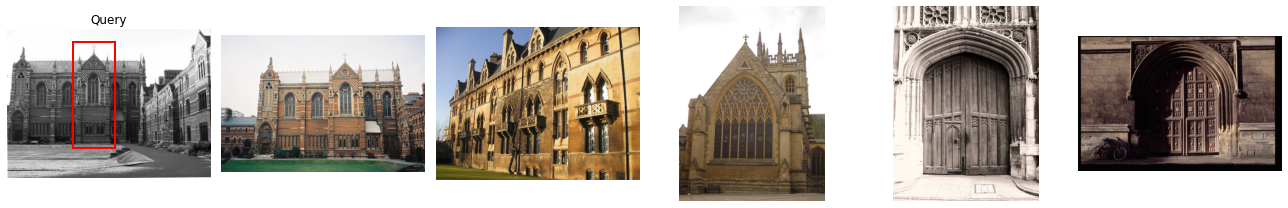

Peor pos:11 AP: 0.0


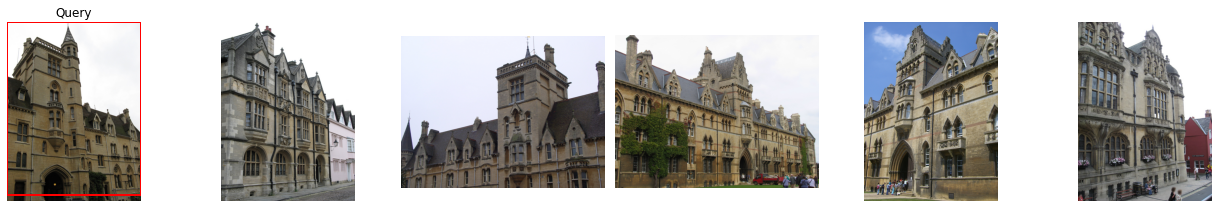

In [44]:
plot_mejor_peor(aps_easy, data_roxford5k, ranks, dataset_name = "roxford5k")

Mejor pos:52 AP: 0.8493563170054317


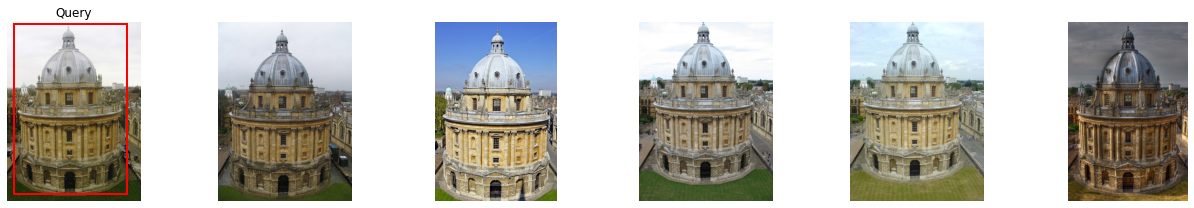

Peor pos:11 AP: 0.001982953023674439


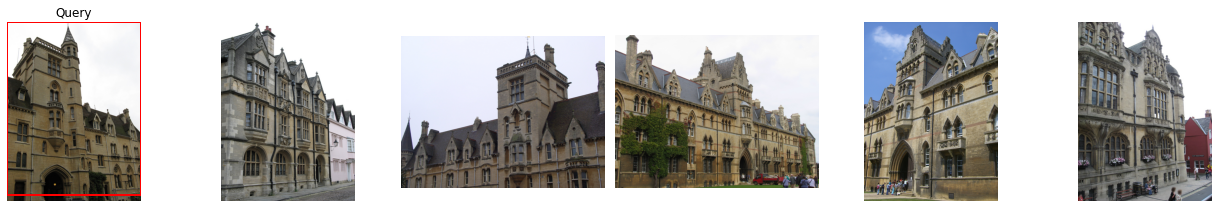

In [45]:
plot_mejor_peor(aps_medium, data_roxford5k, ranks, dataset_name = "roxford5k")

Mejor pos:69 AP: 0.7261980223503525


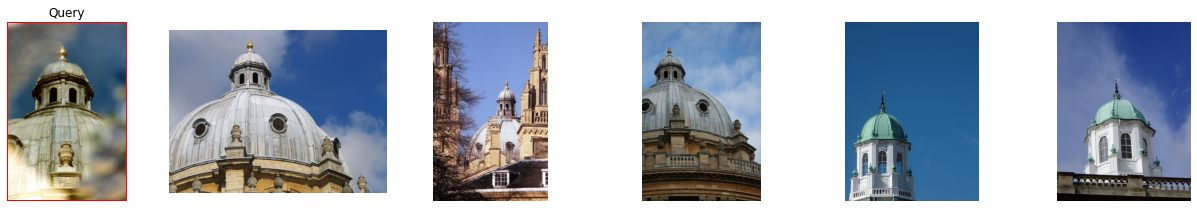

Peor pos:48 AP: 0.00026219192448872575


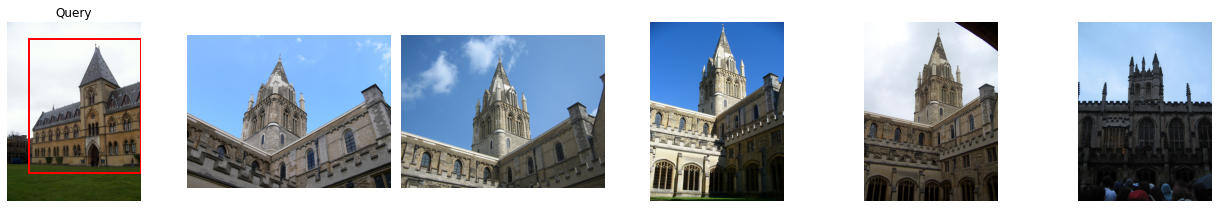

In [46]:
plot_mejor_peor(aps_hard, data_roxford5k, ranks, dataset_name = "roxford5k")

### Paris

In [47]:
cosine_sim = cosine_similarity(db_features_paris, querys_features_paris)
ranks = np.argsort(cosine_sim, axis=0)[::-1]

In [48]:
aps_easy = get_ap(db_features_paris, querys_features_paris, data_rparis6k, dificultad="easy")
aps_medium= get_ap(db_features_paris, querys_features_paris, data_rparis6k, dificultad="medium")
aps_hard= get_ap(db_features_paris, querys_features_paris, data_rparis6k, dificultad="hard")

Mejor pos:55 AP: 1.0


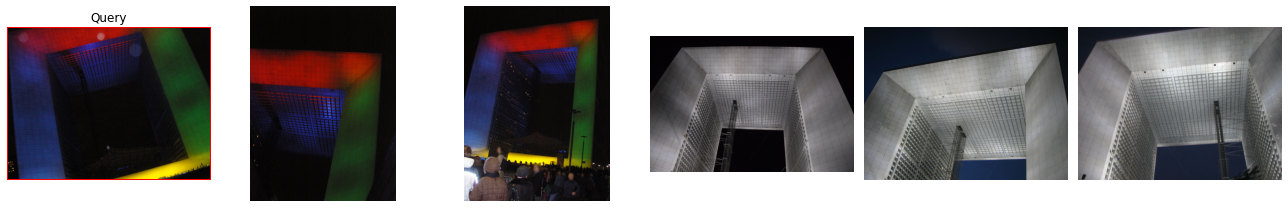

Peor pos:69 AP: 0.0013020817383776412


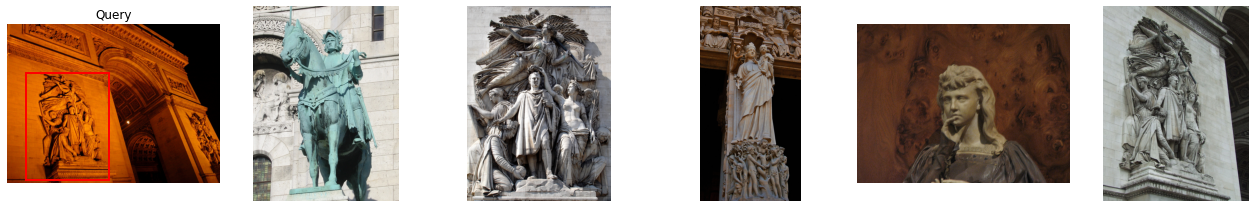

In [49]:
plot_mejor_peor(aps_easy, data_rparis6k, ranks, dataset_name = "rparis6k")

Mejor pos:42 AP: 0.9140695404423786


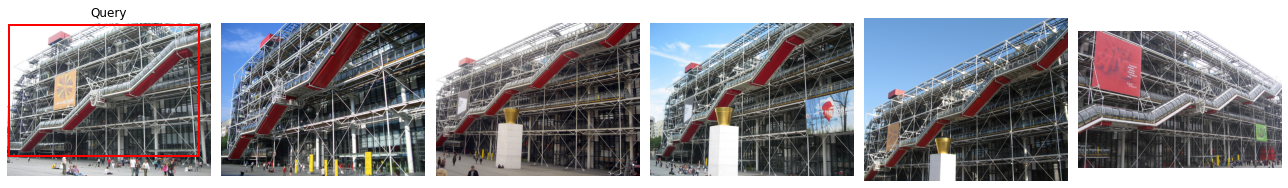

Peor pos:69 AP: 0.020534594367951648


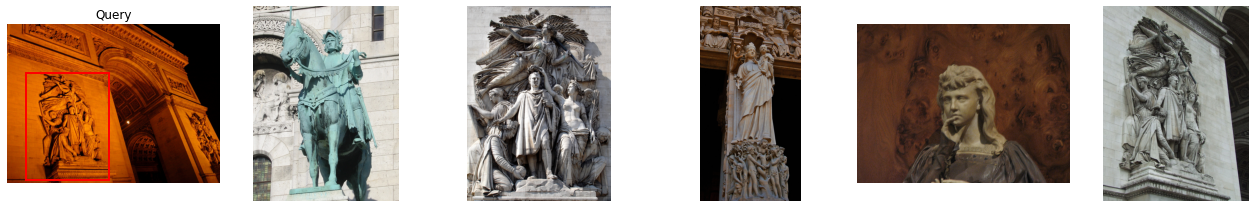

In [50]:
plot_mejor_peor(aps_medium, data_rparis6k, ranks, dataset_name = "rparis6k")

Mejor pos:58 AP: 0.5859324621376581


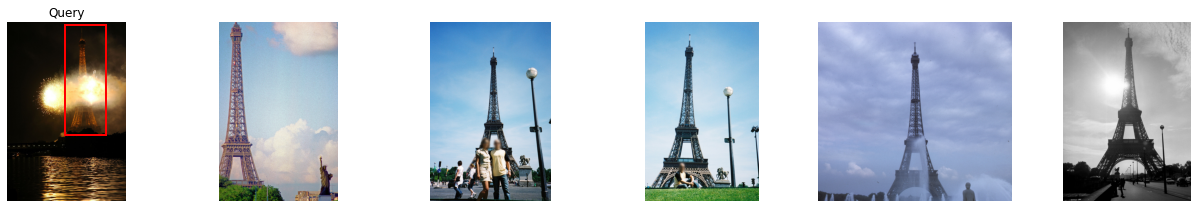

Peor pos:26 AP: 0.018225108443046


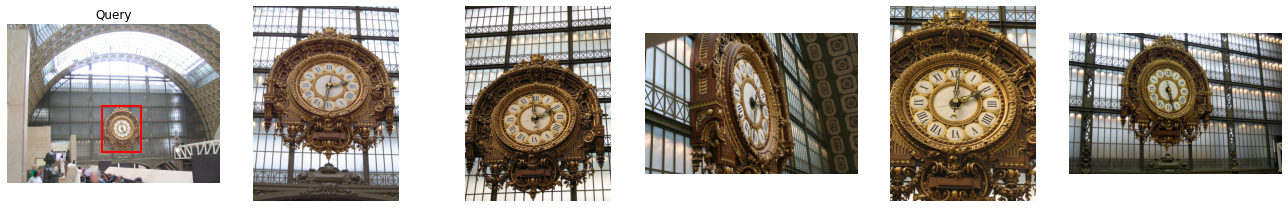

In [51]:
plot_mejor_peor(aps_hard, data_rparis6k, ranks, dataset_name = "rparis6k")